In [53]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample

%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [10]:
params = Table.read('line_fit_params.ecsv')

In [11]:
a, m, s = params['AMPLITUDE'], params['MEAN'], params['STDDEV']

In [12]:
for i in range(len(a)):
    if i == 0:
        lines_mod = models.Gaussian1D(a[i], m[i], s[i])
    else:
        lines_mod = lines_mod + models.Gaussian1D(a[i], m[i], s[i])

In [16]:
mw = np.arange(1000, 3000, 0.01)

(1170, 1180)

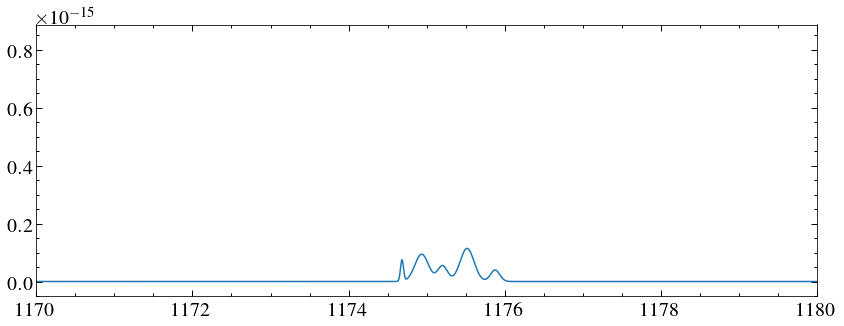

In [17]:
plt.plot(mw, lines_mod(mw))
plt.xlim(1170, 1180)

Yay!

In [18]:
hdul = fits.open('../dem/trappist-1_dem_spectra.fits')

In [19]:
hdul.info()

Filename: ../dem/trappist-1_dem_spectra.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     17   400R x 3C   [D, D, D]   


In [28]:
data = hdul[1].data

In [33]:
w, f, e = data['Wavelength'], data['Bin-Integrated Flux'], data['Error']

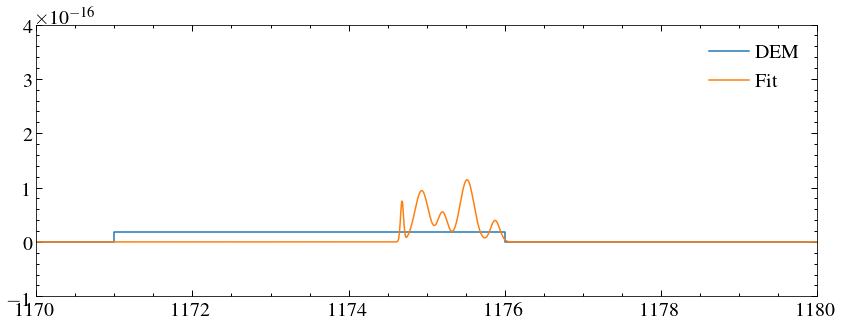

In [50]:
plt.step(w,f, label = 'DEM')
plt.plot(mw, lines_mod(mw), label ='Fit')
plt.ylim(-0.1e-15, 0.4e-15)
plt.xlim(1170, 1180)
plt.legend()

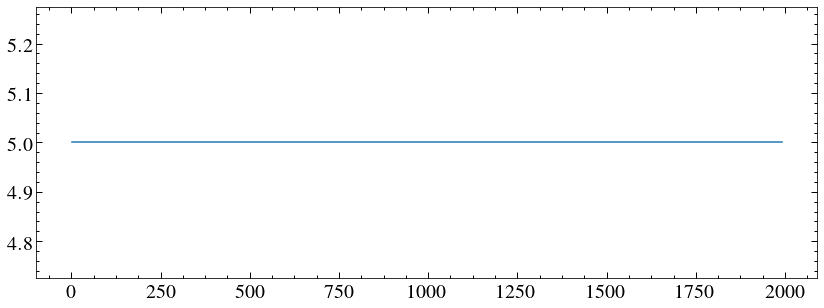

In [40]:
plt.plot(w[:-1], np.diff(w) )

In [42]:
mf = lines_mod(mw)

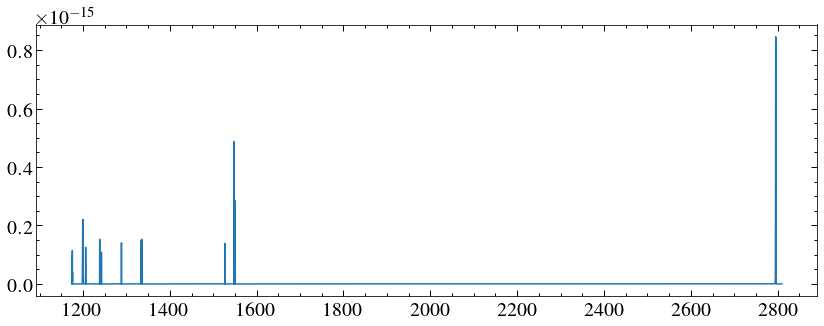

In [44]:
mask = mf >0
plt.step(mw[mask], mf[mask])

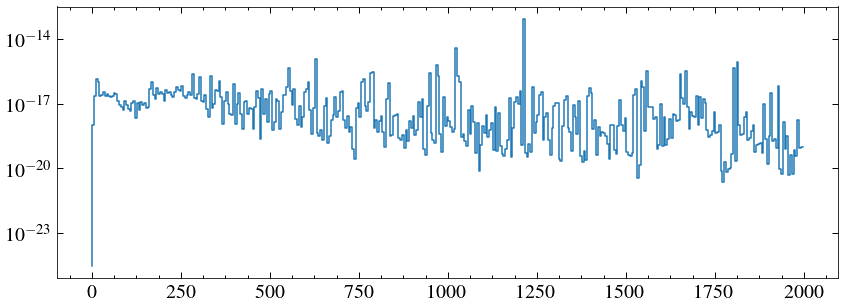

In [54]:
plt.step(w,f)
#plt.xscale('log')
plt.yscale('log')
#plt.plot(mw[mask], mf[mask])

In [70]:
mw = np.arange(w[0], w[-1], 0.01)

In [71]:
mf = lines_mod(mw)

In [72]:
#mask = (w > mw[0]) & (w< mw[-1])
#w2, f2 = w[mask], f[mask]
w2, f2 = resample.bintogrid(w,f, newx=mw)

In [73]:
mf2 = f2+mf

(1237, 1243)

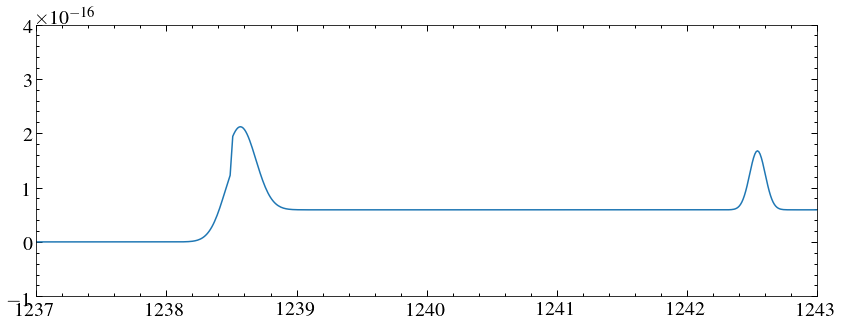

In [75]:
plt.plot(mw, mf2)
plt.ylim(-0.1e-15, 0.4e-15)
plt.xlim(1237, 1243)

Ok that's not going to work. Need to remove the lines from the DEM then add in the fitted lines.